## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Directories

In [ ]:
# Image directories
train_img_folder = '/content/drive/MyDrive/CAD/Dataset/train/train'
val_img_folder = '/content/drive/MyDrive/CAD/Dataset/val/val'
test_img_folder = '/content/drive/MyDrive/CAD/Dataset/test'

# CSV paths
train_csv_path = '/content/drive/MyDrive/CAD/Dataset/train_labels.csv'
val_csv_path = '/content/drive/MyDrive/CAD/Dataset/val_labels.csv'
test_csv_path = '/content/drive/MyDrive/CAD/Dataset/test_ids.csv'

#### Parameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NEW_SIZE = 256
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2
MU = [0.6138, 0.5056, 0.4985]
STD = [0.1611, 0.1672, 0.1764]

#### Data Transformations

In [ ]:
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= MU, std=STD)
                                  ])

In [ ]:
dataset_train = Challenge2Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True)

In [ ]:
dataset_val = Challenge2Dataset(csv_file=val_csv_path,
                            image_folder= val_img_folder,
                            img_transform = img_transforms,
                            augment=False)


#### Data Loaders

In [ ]:
y = dataset_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(dataset_train.get_labels(), 'mean') 
data_sampler = ImbalancedDatasetSampler(dataset_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(dataset_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loader_shuff = DataLoader(dataset_val, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)


In [ ]:
dataloaders = {"train": train_loader,"val": val_loader}
dataloaders_balanced = {"train": train_loader_balanced,"val": val_loader}

# Training and Results

#### Resnet Model 

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/CAD/ResNet/resnet_ce_samp.txt", level=logging.INFO, format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/CAD/ResNet/'

In [ ]:
resnet = model_factory.make_resnet(True, DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr = LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.5, mode="min")
logging.info('Model:Resnet, LR: 1e-4, LR patience = 7, loss: CE + sampling, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8')

Model:Resnet, LR: 1e-4, LR patience = 7, loss: CE + sampling, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8


In [ ]:
#number of samples in each set
dataset_sizes = {'train': mean_samples,'val':len(dataset_val)}

In [ ]:
checkpoint_p = '/content/drive/MyDrive/CAD/ResNet/resnet_ce_samp.pth'
resnet = train_model(resnet, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:05<00:00,  2.54it/s]

train epoch 1 : loss : 0.5840, acc: 0.7753, kappa: 0.5741



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 1 : loss : 0.3973, acc: 0.8528, kappa: 0.7212



Epoch 2/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 2 : loss : 0.4499, acc: 0.8333, kappa: 0.6880



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

val epoch 2 : loss : 0.3541, acc: 0.8598, kappa: 0.7392



Epoch 3/100
---------------


100%|██████████| 318/318 [01:49<00:00,  2.91it/s]

train epoch 3 : loss : 0.4113, acc: 0.8434, kappa: 0.7094



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 3 : loss : 0.3254, acc: 0.8811, kappa: 0.7790



Epoch 4/100
---------------


100%|██████████| 318/318 [01:46<00:00,  2.98it/s]

train epoch 4 : loss : 0.3609, acc: 0.8656, kappa: 0.7528



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 4 : loss : 0.3029, acc: 0.8850, kappa: 0.7894



Epoch 5/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 5 : loss : 0.3347, acc: 0.8737, kappa: 0.7680



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


val epoch 5 : loss : 0.2723, acc: 0.9016, kappa: 0.8181

Epoch 6/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.97it/s]

train epoch 6 : loss : 0.3042, acc: 0.8878, kappa: 0.7947



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 6 : loss : 0.2805, acc: 0.9016, kappa: 0.8206



Epoch 7/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 7 : loss : 0.2742, acc: 0.9002, kappa: 0.8180



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 7 : loss : 0.3105, acc: 0.8795, kappa: 0.7815



Epoch 8/100
---------------


100%|██████████| 318/318 [01:45<00:00,  3.02it/s]

train epoch 8 : loss : 0.2577, acc: 0.9034, kappa: 0.8239



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 8 : loss : 0.2936, acc: 0.8976, kappa: 0.8114



Epoch 9/100
---------------


100%|██████████| 318/318 [01:46<00:00,  2.99it/s]

train epoch 9 : loss : 0.2428, acc: 0.9044, kappa: 0.8261



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


val epoch 9 : loss : 0.2288, acc: 0.9165, kappa: 0.8491

Epoch 10/100
---------------


100%|██████████| 318/318 [01:46<00:00,  3.00it/s]

train epoch 10 : loss : 0.2288, acc: 0.9156, kappa: 0.8468



100%|██████████| 20/20 [00:25<00:00,  1.26s/it]

val epoch 10 : loss : 0.2553, acc: 0.9031, kappa: 0.8257



Epoch 11/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 11 : loss : 0.2200, acc: 0.9152, kappa: 0.8454



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 11 : loss : 0.2434, acc: 0.9157, kappa: 0.8477



Epoch 12/100
---------------


100%|██████████| 318/318 [01:45<00:00,  3.00it/s]


train epoch 12 : loss : 0.2007, acc: 0.9299, kappa: 0.8732


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 12 : loss : 0.2318, acc: 0.9173, kappa: 0.8504



Epoch 13/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 13 : loss : 0.1784, acc: 0.9355, kappa: 0.8833



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

val epoch 13 : loss : 0.2420, acc: 0.9220, kappa: 0.8583



Epoch 14/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.94it/s]

train epoch 14 : loss : 0.1888, acc: 0.9355, kappa: 0.8832



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 14 : loss : 0.2481, acc: 0.9173, kappa: 0.8510



Epoch 15/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.95it/s]

train epoch 15 : loss : 0.1679, acc: 0.9402, kappa: 0.8918



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 15 : loss : 0.4148, acc: 0.8701, kappa: 0.7738



Epoch 16/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 16 : loss : 0.1707, acc: 0.9313, kappa: 0.8758



100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

val epoch 16 : loss : 0.2253, acc: 0.9197, kappa: 0.8541



Epoch 17/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.06it/s]

train epoch 17 : loss : 0.1481, acc: 0.9443, kappa: 0.8993



100%|██████████| 20/20 [00:23<00:00,  1.19s/it]

val epoch 17 : loss : 0.2216, acc: 0.9268, kappa: 0.8689



Epoch 18/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.04it/s]

train epoch 18 : loss : 0.1446, acc: 0.9461, kappa: 0.9025



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 18 : loss : 0.2155, acc: 0.9339, kappa: 0.8812



Epoch 19/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 19 : loss : 0.1504, acc: 0.9471, kappa: 0.9044



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 19 : loss : 0.1997, acc: 0.9362, kappa: 0.8847



Epoch 20/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.04it/s]

train epoch 20 : loss : 0.1234, acc: 0.9561, kappa: 0.9209



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

val epoch 20 : loss : 0.2272, acc: 0.9283, kappa: 0.8703



Epoch 21/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 21 : loss : 0.1283, acc: 0.9482, kappa: 0.9067



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 21 : loss : 0.1953, acc: 0.9402, kappa: 0.8924



Epoch 22/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.07it/s]

train epoch 22 : loss : 0.1136, acc: 0.9589, kappa: 0.9258



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 22 : loss : 0.2176, acc: 0.9315, kappa: 0.8768



Epoch 23/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.08it/s]

train epoch 23 : loss : 0.1116, acc: 0.9597, kappa: 0.9273



100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

val epoch 23 : loss : 0.2075, acc: 0.9346, kappa: 0.8817



Epoch 24/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 24 : loss : 0.1242, acc: 0.9530, kappa: 0.9150



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 24 : loss : 0.1788, acc: 0.9472, kappa: 0.9051



Epoch 25/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 25 : loss : 0.1097, acc: 0.9599, kappa: 0.9276



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 25 : loss : 0.2073, acc: 0.9331, kappa: 0.8806



Epoch 26/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.09it/s]

train epoch 26 : loss : 0.0924, acc: 0.9673, kappa: 0.9411



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 26 : loss : 0.2320, acc: 0.9339, kappa: 0.8818



Epoch 27/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.10it/s]

train epoch 27 : loss : 0.1125, acc: 0.9624, kappa: 0.9322



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

val epoch 27 : loss : 0.2876, acc: 0.9039, kappa: 0.8334



Epoch 28/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.08it/s]

train epoch 28 : loss : 0.1025, acc: 0.9632, kappa: 0.9337



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 28 : loss : 0.1878, acc: 0.9441, kappa: 0.8989



Epoch 29/100
---------------


100%|██████████| 318/318 [01:41<00:00,  3.12it/s]

train epoch 29 : loss : 0.0961, acc: 0.9667, kappa: 0.9401



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 29 : loss : 0.2137, acc: 0.9409, kappa: 0.8941



Epoch 30/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 30 : loss : 0.0930, acc: 0.9671, kappa: 0.9407



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 30 : loss : 0.2096, acc: 0.9346, kappa: 0.8831



Epoch 31/100
---------------


100%|██████████| 318/318 [01:40<00:00,  3.18it/s]

train epoch 31 : loss : 0.1003, acc: 0.9648, kappa: 0.9365



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 31 : loss : 0.2046, acc: 0.9339, kappa: 0.8813



Epoch 32/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.10it/s]

train epoch 32 : loss : 0.0904, acc: 0.9660, kappa: 0.9386



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 32 : loss : 0.1993, acc: 0.9402, kappa: 0.8917



Epoch 33/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.09it/s]

train epoch 33 : loss : 0.0561, acc: 0.9795, kappa: 0.9631



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 33 : loss : 0.1740, acc: 0.9551, kappa: 0.9191



Epoch 34/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.09it/s]

train epoch 34 : loss : 0.0492, acc: 0.9841, kappa: 0.9713



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

val epoch 34 : loss : 0.1786, acc: 0.9480, kappa: 0.9067



Epoch 35/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.08it/s]

train epoch 35 : loss : 0.0510, acc: 0.9825, kappa: 0.9684



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]

val epoch 35 : loss : 0.1680, acc: 0.9504, kappa: 0.9110



Epoch 36/100
---------------


100%|██████████| 318/318 [01:46<00:00,  2.98it/s]

train epoch 36 : loss : 0.0471, acc: 0.9862, kappa: 0.9752



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 36 : loss : 0.1602, acc: 0.9528, kappa: 0.9148



Epoch 37/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.06it/s]

train epoch 37 : loss : 0.0467, acc: 0.9829, kappa: 0.9691



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 37 : loss : 0.1961, acc: 0.9449, kappa: 0.9012



Epoch 38/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.08it/s]

train epoch 38 : loss : 0.0412, acc: 0.9835, kappa: 0.9702



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 38 : loss : 0.1899, acc: 0.9465, kappa: 0.9043



Epoch 39/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.09it/s]

train epoch 39 : loss : 0.0429, acc: 0.9845, kappa: 0.9720



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 39 : loss : 0.2018, acc: 0.9409, kappa: 0.8942



Epoch 40/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.11it/s]

train epoch 40 : loss : 0.0328, acc: 0.9892, kappa: 0.9805



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 40 : loss : 0.2061, acc: 0.9425, kappa: 0.8974



Epoch 41/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.11it/s]

train epoch 41 : loss : 0.0420, acc: 0.9847, kappa: 0.9724



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

val epoch 41 : loss : 0.1639, acc: 0.9528, kappa: 0.9149



Epoch 42/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.04it/s]

train epoch 42 : loss : 0.0340, acc: 0.9884, kappa: 0.9791



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 42 : loss : 0.1633, acc: 0.9583, kappa: 0.9254



Epoch 43/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.11it/s]

train epoch 43 : loss : 0.0349, acc: 0.9876, kappa: 0.9777



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 43 : loss : 0.1752, acc: 0.9520, kappa: 0.9133



Epoch 44/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.11it/s]

train epoch 44 : loss : 0.0421, acc: 0.9843, kappa: 0.9716



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 44 : loss : 0.2189, acc: 0.9465, kappa: 0.9035



Epoch 45/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.10it/s]

train epoch 45 : loss : 0.0364, acc: 0.9878, kappa: 0.9780



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


val epoch 45 : loss : 0.1531, acc: 0.9535, kappa: 0.9163

Epoch 46/100
---------------


100%|██████████| 318/318 [01:40<00:00,  3.17it/s]

train epoch 46 : loss : 0.0295, acc: 0.9900, kappa: 0.9819



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 46 : loss : 0.1534, acc: 0.9591, kappa: 0.9263



Epoch 47/100
---------------


100%|██████████| 318/318 [01:48<00:00,  2.92it/s]

train epoch 47 : loss : 0.0245, acc: 0.9917, kappa: 0.9851



100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

val epoch 47 : loss : 0.1470, acc: 0.9598, kappa: 0.9278



Epoch 48/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 48 : loss : 0.0192, acc: 0.9925, kappa: 0.9865



100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

val epoch 48 : loss : 0.1555, acc: 0.9598, kappa: 0.9276



Epoch 49/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.10it/s]

train epoch 49 : loss : 0.0195, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 49 : loss : 0.1698, acc: 0.9559, kappa: 0.9208



Epoch 50/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.09it/s]

train epoch 50 : loss : 0.0195, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:24<00:00,  1.22s/it]

val epoch 50 : loss : 0.1776, acc: 0.9535, kappa: 0.9161



Epoch 51/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.11it/s]

train epoch 51 : loss : 0.0198, acc: 0.9931, kappa: 0.9876



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 51 : loss : 0.2068, acc: 0.9496, kappa: 0.9088



Epoch 52/100
---------------


100%|██████████| 318/318 [01:45<00:00,  3.02it/s]

train epoch 52 : loss : 0.0211, acc: 0.9937, kappa: 0.9887



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 52 : loss : 0.1753, acc: 0.9535, kappa: 0.9165



Epoch 53/100
---------------


100%|██████████| 318/318 [01:43<00:00,  3.06it/s]

train epoch 53 : loss : 0.0268, acc: 0.9911, kappa: 0.9841



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 53 : loss : 0.1887, acc: 0.9567, kappa: 0.9221



Epoch 54/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.04it/s]

train epoch 54 : loss : 0.0205, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 54 : loss : 0.1592, acc: 0.9496, kappa: 0.9095



Epoch 55/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 55 : loss : 0.0189, acc: 0.9949, kappa: 0.9908



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 55 : loss : 0.1660, acc: 0.9583, kappa: 0.9249



Epoch 56/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 56 : loss : 0.0173, acc: 0.9945, kappa: 0.9901



100%|██████████| 20/20 [00:24<00:00,  1.23s/it]

val epoch 56 : loss : 0.1673, acc: 0.9567, kappa: 0.9219



Epoch 57/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.05it/s]

train epoch 57 : loss : 0.0172, acc: 0.9925, kappa: 0.9865



100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

val epoch 57 : loss : 0.1579, acc: 0.9559, kappa: 0.9205



Epoch 58/100
---------------


100%|██████████| 318/318 [01:42<00:00,  3.09it/s]

train epoch 58 : loss : 0.0148, acc: 0.9943, kappa: 0.9897



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]

val epoch 58 : loss : 0.1578, acc: 0.9559, kappa: 0.9201



Epoch 59/100
---------------


100%|██████████| 318/318 [01:44<00:00,  3.03it/s]

train epoch 59 : loss : 0.0154, acc: 0.9957, kappa: 0.9922



100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

val epoch 59 : loss : 0.1589, acc: 0.9591, kappa: 0.9265



Epoch 60/100
---------------


100%|██████████| 318/318 [01:47<00:00,  2.96it/s]

train epoch 60 : loss : 0.0137, acc: 0.9967, kappa: 0.9940



100%|██████████| 20/20 [00:23<00:00,  1.15s/it]

val epoch 60 : loss : 0.1528, acc: 0.9598, kappa: 0.9276


EARLY STOP AFTER 60 EPOCHS
Training complete in 130m 27s
Best val loss: 0.147039
Best val Kappa: 0.92783286908078


#### Load the saved model

In [ ]:
resnet_best_2 = model_factory.make_resnet(False, DEVICE)
resnet_best_2.load_state_dict(torch.load('/content/drive/MyDrive/CAD/ResNet/resnet_ce_samp_best.pth'))

<All keys matched successfully>

In [ ]:
since = time.time()

resnet_best_2.eval()
running_labels = []
running_preds = []
outputs_all = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = resnet_best_2(inputs)
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        probas = F.softmax(outputs, dim=1)
        outputs_all.append(probas.cpu().numpy())
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

Test Acc: 0.9598, kappa: 0.9278
Testing complete in 0m 25s


Confusion matrix, without normalization
[[655  14   9]
 [  8 484   6]
 [ 11   3  80]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

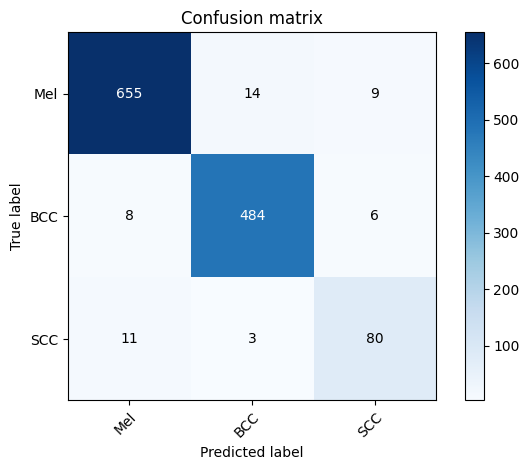

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

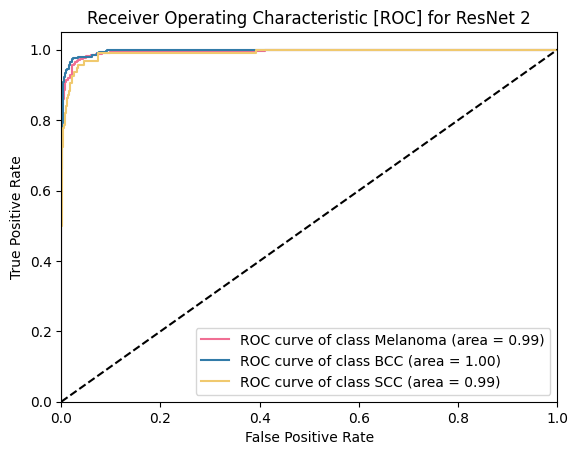

{0: 0.9943469465040261, 1: 0.9968136795888216, 2: 0.9905377044434795}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'ResNet 2')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():
  img_id = '/' + row['Image_ID']

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path)  
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = resnet_best_2(image)
  outputs = outputs_1
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


#### Save prediction in Excel File

In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_resnet_2.csv')